In [1]:
import numpy as np
import torch
import torchvision as tvis
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
torch.cuda.is_available()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


True

In [3]:
batch_size = 200
input_dimension = int(28*28)

In [4]:
data_dir = "./gdrive/My Drive/coding_projects/data"

def get_train_valid_loader(data_dir,
                           batch_size,
                           random_seed,
                           valid_size=0.02,
                           shuffle=True,
                           num_workers=2,
                           pin_memory=True):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor()        ])
    train_transform = transforms.Compose([
            transforms.ToTensor()
        ])

    # load the dataset
    train_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=False, transform=train_transform)

    valid_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=False, transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                    batch_size=batch_size, sampler=train_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                    batch_size=batch_size, sampler=valid_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    return (train_loader, valid_loader)
  
tr_load, vl_load = get_train_valid_loader(data_dir,batch_size=batch_size, num_workers=2, random_seed=0)

In [5]:
class CouplingBlock(nn.Module):
    '''
    Arguments: 
    hidden_dims = Dimensions of MLP: [dim_in, n_hidden, .. , dim_out]
    
    Forward Returns:
    x = Output MLP of size [batch_size, dim_out]
    '''
    def __init__(self,
                 hidden_dims,
                 *args, **kwargs):
        super(CouplingBlock, self).__init__()
        self.hidden = nn.ModuleList()
        for k in range(len(hidden_dims)-2):
            self.hidden.append(nn.Sequential(
                nn.Linear(hidden_dims[k], hidden_dims[k+1]),
                nn.ReLU()))
        self.hidden.append(nn.Linear(hidden_dims[-2], hidden_dims[-1]))
    def forward(self, x):
        for layer in self.hidden:
            x  = layer(x)
        return x
        

In [6]:
class Net(nn.Module):
    def __init__(self, input_size, num_hidden_units=1000,
                num_hidden_layers=5, block=CouplingBlock, 
                *args, **kwargs):
        super(Net, self).__init__()
        dim = int(input_size//2)+int(input_size%2)
        block_shape = [dim] + [num_hidden_units]*num_hidden_layers + [dim]
        self.input_size = input_size
        self.block1 = block(block_shape) 
        self.block2 = block(block_shape) 
        self.block3 = block(block_shape)
        self.block4 = block(block_shape)
        self.final_layer = nn.Parameter(torch.zeros((1, input_size)), requires_grad=True)
        #self.scaling = scaling(input_size)
        if torch.cuda.is_available():  
          dev = "cuda:0" 
        else:  
          dev = "cpu" 
        self.device = torch.device(dev)

    def idx_ev(self,z):
        return(torch.tensor([True,False]*int(z.shape[1]//2)+[True]*int(z.shape[1]%2)).reshape(1,z.shape[1]).repeat(z.shape[0],1)).to(self.device)
    def idx_od(self,z):
        return(torch.tensor([False,True]*int(z.shape[1]//2)+[False]*int(z.shape[1]%2)).reshape(1,z.shape[1]).repeat(z.shape[0],1)).to(self.device)
    def split_vector(self, x, coeff=0):
        BS, DIM = x.shape[0], x.shape[1]
        x = x.reshape(BS,DIM//2,2)
        if coeff:
          return x[:,:,0], x[:,:,1]
        else:
          return x[:,:,1], x[:,:,0]

    def split_and_pass(self, x, block, coeff=0, forward=True):
        BS, DIM = x.shape[0], x.shape[1]
        split_0, split_1 = self.split_vector(x, coeff=coeff)
        split_block = block(split_1)
        if forward:
          split_0_shift = split_0 + split_block
        else:
          split_0_shift = split_0 - split_block
        
        if coeff:
          return(torch.stack((split_0,split_1), axis=2).reshape(BS,DIM))
        else:
          return(torch.stack((split_1,split_0), axis=2).reshape(BS,DIM))
    '''
    def x_to_z(self,x):
        h1 = self.split_and_pass(x,block=self.block1,coeff=0,forward=True)
        h2 = self.split_and_pass(h1,block=self.block2,coeff=1,forward=True)
        h3 = self.split_and_pass(h2,block=self.block3,coeff=0,forward=True)
        h4 = self.split_and_pass(h3,block=self.block4,coeff=1,forward=True)
        z   = h4*torch.exp(self.final_layer)
        #z,ss = self.scaling(h4, reverse=False)
        #return(z,ss)
        return(z)
    def z_to_x(self,z):
        h4 = z*torch.exp(-self.final_layer)
        #h4, ss = self.scaling(z, reverse=True)
        h3 = self.split_and_pass(h4,block=self.block4,coeff=1,forward=False)
        h2 = self.split_and_pass(h3,block=self.block3,coeff=0,forward=False)
        h1 = self.split_and_pass(h2,block=self.block2,coeff=1,forward=False)
        x  = self.split_and_pass(h1,block=self.block1,coeff=0,forward=False)
        return(x)
    '''
    def x_to_z(self,x):

        #h_1[odd] = x[odd]
        #h_1[eve] = x[even] + block(x[odd])
        x.masked_scatter_(self.idx_ev(x),x[self.idx_ev(x)].view(batch_size,-1)+self.block1.forward(x[self.idx_od(x)].view(batch_size,-1))) 
        
        #h_2[even] = h_1[even]
        #h_2[odd]  = h_1[odd] + block(x[even])
        x.masked_scatter_(self.idx_od(x),x[self.idx_od(x)].view(batch_size,-1)+self.block2.forward(x[self.idx_ev(x)].view(batch_size,-1))) 
        
        #h_3[odd]  = h_2[odd]
        #h_3[even] = h_1[even] + block(x[odd])
        x.masked_scatter_(self.idx_ev(x),x[self.idx_ev(x)].view(batch_size,-1)+self.block3.forward(x[self.idx_od(x)].view(batch_size,-1))) 
    
        #h_4[even] = h_3[even]
        #h_4[odd]  = h_3[odd]  + block(x[even])
        x.masked_scatter_(self.idx_od(x),x[self.idx_od(x)].view(batch_size,-1)+self.block4.forward(x[self.idx_ev(x)].view(batch_size,-1))) 
      
        #h = exp(s)*h_4
        h = x*torch.exp(self.final_layer)
        return h#, self.final_layer

    def z_to_x(self,h):
        batch_size=h.shape[0]
        #reverse h=f(x) --> x=g(h) | g=f^-1
        h = h * torch.exp(-self.final_layer)
        h.masked_scatter_(self.idx_od(h),h[self.idx_od(h)].view(batch_size,-1)-self.block4.forward(h[self.idx_ev(h)].view(batch_size,-1)))
        h.masked_scatter_(self.idx_ev(h),h[self.idx_ev(h)].view(batch_size,-1)-self.block3.forward(h[self.idx_od(h)].view(batch_size,-1)))
        h.masked_scatter_(self.idx_od(h),h[self.idx_od(h)].view(batch_size,-1)-self.block2.forward(h[self.idx_ev(h)].view(batch_size,-1)))
        h.masked_scatter_(self.idx_ev(h),h[self.idx_ev(h)].view(batch_size,-1)-self.block1.forward(h[self.idx_od(h)].view(batch_size,-1)))
        return h

    def compute_loss(self, x):
        #x: [BS,D], s: [D]
        #h, s = self.f_g(x)
        #J = torch.sum(-torch.log(1+torch.exp(h)) - torch.log(1+torch.exp(-h)), axis=1) + torch.sum(s)
        #J = -(F.softplus(x) + F.softplus(-x))
        #if self.reduce_batch:
        #    J = torch.mean(J)
        #return -J
        return -(F.softplus(x) + F.softplus(-x))
    
    def forward(self,x):
        #z,ss   = self.x_to_z(x)
        z   = self.x_to_z(x)
        J_z = torch.sum(self.compute_loss(z),axis=1)
        J_s = torch.sum(self.final_layer)
        #return -(J_z+ss).mean()
        return -(J_z+J_s).mean()
    
    def sample_x(self,num):
        shape  = [num, self.input_size]
        z_unif = torch.distributions.Uniform(0., 1.).sample(shape).to(self.device)
        z = torch.log(z_unif) - torch.log(1. - z_unif)
        x = self.z_to_x(z)
        return x



if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 
model = Net(input_size=input_dimension, num_hidden_units=1000, num_hidden_layers=5).to(device)
#summary(model, (784,))


In [7]:
def dequantize(x, dataset="mnist"):
    noise = torch.distributions.Uniform(0., 1.).sample(x.size())
    return (x * 255. + noise) / 256.

def prepare_data(x, dataset, zca=None, mean=None, reverse=False):
    if reverse:
        assert len(list(x.size())) == 2
        [B, W] = list(x.size())

        if dataset in ['mnist', 'fashion-mnist']:
            assert W == 1 * 28 * 28
            x += mean
            x = x.reshape((B, 1, 28, 28))
    else:
        assert len(list(x.size())) == 4
        [B, C, H, W] = list(x.size())

        if dataset in ['mnist', 'fashion-mnist']:
            assert [C, H, W] == [1, 28, 28]

        x = dequantize(x, dataset)
        x = x.reshape((B, C*H*W))

        if dataset in ['mnist', 'fashion-mnist']:
            x -= mean
    return x

In [8]:
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-3,betas=(0.9, 0.999),eps=1e-4)
mean = torch.load("./gdrive/My Drive/coding_projects/data/MNIST/mnist_mean.pt")


In [9]:
epochs = 80
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(tr_load, 1):
        model.train()
        optimizer.zero_grad()
        inputs_raw,_ = data
        inputs = prepare_data(inputs_raw, dataset="mnist", zca=None, mean=mean).to(device)
        loss = model(inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # print running loss
    if epoch % 5 == 0:
        print('Epoch %d ---> Running Loss Average: %.3f' % (epoch, running_loss / np.float(i)))
        running_loss = 0.0



Epoch 0 ---> Running Loss Average: 978.944
Epoch 5 ---> Running Loss Average: -123.063
Epoch 10 ---> Running Loss Average: -950.475
Epoch 15 ---> Running Loss Average: -1477.073
Epoch 20 ---> Running Loss Average: -1813.250
Epoch 25 ---> Running Loss Average: -1964.977
Epoch 30 ---> Running Loss Average: -2010.166
Epoch 35 ---> Running Loss Average: -2033.682
Epoch 40 ---> Running Loss Average: -2048.297
Epoch 45 ---> Running Loss Average: -2062.508
Epoch 50 ---> Running Loss Average: -2071.620
Epoch 55 ---> Running Loss Average: -2079.969
Epoch 60 ---> Running Loss Average: -2086.790
Epoch 65 ---> Running Loss Average: -2091.423
Epoch 70 ---> Running Loss Average: -2097.223
Epoch 75 ---> Running Loss Average: -2101.624


In [10]:
sample_size = 200
model.eval()
with torch.no_grad():
    inputs_raw,_ = data
    inputs = prepare_data(inputs_raw, dataset="mnist", zca=None, mean=mean).to(device)
    z = model.x_to_z(inputs)
    reconst = model.z_to_x(z)
    samples = model.sample_x(sample_size)


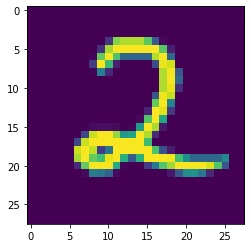

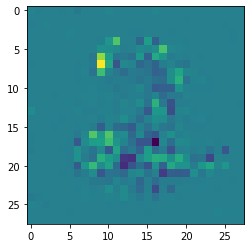

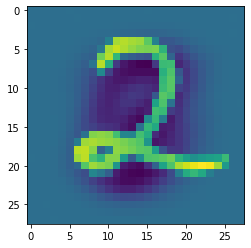

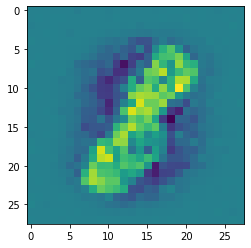

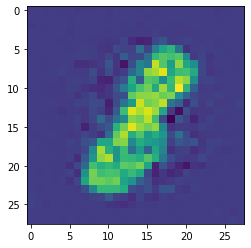

In [15]:
# plot inputs_raw
idx_ = 100
plt.figure()
plt.imshow(inputs_raw[idx_].reshape(28,28))

# plot inputs
plt.figure()
plt.imshow(inputs.reshape((batch_size,1,28,28)).cpu().detach().numpy()[idx_,0,:,:]) 

# plot reconstruction 
plt.figure()
plt.imshow(reconst.reshape((batch_size,1,28,28)).cpu().detach().numpy()[idx_,0,:,:]) 

# plot sample 
plt.figure()
plt.imshow(samples.reshape((sample_size,1,28,28)).cpu().detach().numpy()[idx_,0,:,:]) 

# plot samples after prepare 
samples_prep = prepare_data(samples.cpu(), dataset="mnist", zca=None, mean=mean, reverse=True)
plt.figure()
plt.imshow(samples_prep.reshape((sample_size,1,28,28)).cpu().detach().numpy()[idx_,0,:,:]) 
